In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [2]:
device = torch.device("cuda:1")
# device = torch.device("cpu")

In [3]:
import umap

## MNIST dataset

In [4]:
import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [5]:
mnist = datasets.FashionMNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [6]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [7]:
input_size = 784
output_size = 10

In [8]:
class MNIST_Dataset(data.Dataset):
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
#         print(idx)
        img, lbl = self.data[idx], self.label[idx]
        return img, lbl

In [9]:
train_dataset = MNIST_Dataset(train_data, train_label)
test_dataset = MNIST_Dataset(test_data, test_label)

In [10]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset,
                                    num_workers=4, 
                                    batch_size=batch_size, 
                                    shuffle=True)

test_loader = data.DataLoader(dataset=test_dataset,
                                    num_workers=1, 
                                    batch_size=batch_size, 
                                    shuffle=False)

In [11]:
class EMA(object):

    def __init__(self, momentum=0.1, mu=None):
        self.mu = mu
        self.momentum = momentum

    def __call__(self, x):
        if self.mu is None:
            self.mu = x
        self.mu = self.momentum*self.mu + (1.0 - self.momentum)*x
        return self.mu

## Distance Embedding of the data

In [12]:
import dtnnlib as dtnn

In [314]:
NC = 1000
# dt = dtnn.DistanceTransform_Exp(784, NC).to(device)
dt = dtnn.DistanceTransform_MinExp(784, NC).to(device)
# dt.set_centroid_to_data_randomly(train_loader)
indices = np.random.permutation(len(train_loader.dataset.data))[:NC]
xx, yy_ = train_loader.dataset[indices]
dt.centers.data = xx.data.to(device)

indices = np.random.permutation(len(test_loader.dataset.data))[:50]
xx, yy = test_loader.dataset[indices]

dists = dt(xx.to(device))

### Now embedding using UMAP

In [334]:
embedder = umap.UMAP(densmap=False, n_neighbors=100, n_components=2, min_dist=0.1, spread=1)

In [335]:
embedding = embedder.fit_transform(dt.centers.data.cpu().numpy())
embedding

array([[ 5.9798536, 13.980145 ],
       [ 6.0173016,  9.90128  ],
       [11.450241 , 10.242818 ],
       ...,
       [ 7.4348807, 11.535436 ],
       [ 4.758194 ,  9.034034 ],
       [ 5.4078937, 13.261476 ]], dtype=float32)

In [336]:
embedding = embedding - embedding.mean(axis=0, keepdims=True)

In [337]:
output_cent = yy_.data.cpu().numpy()

In [338]:
i = 0

5/50


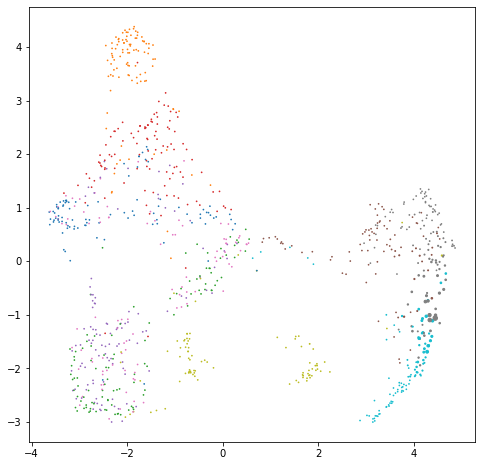

In [343]:
activ = dists.data.cpu().numpy()[i]
# activ = activ - activ.min()
# activ = torch.exp(-activ)
i += 1
print(f"{i}/{len(dists)}")
plt.figure(figsize=(8,8))
plt.scatter(embedding[:,0], embedding[:, 1], c=output_cent, s=np.maximum(activ*20, 0.5), cmap="tab10")

### Use the embedding to select Top-K neurons 

In [344]:
# class SpatialAttention(nn.Module):
    
#     def __init__(self, num_inputs, num_outputs, out_neighbours, inp_neighbours, embedding_dim):
#         super().__init__()
#         self.num_inputs = num_inputs
#         self.num_outputs = num_outputs
#         self.out_neighbours = out_neighbours
#         self.inp_neighbours = inp_neighbours
        
#         embd_dim = embedding_dim
#         self.output_embedding = nn.Parameter(torch.randn(num_outputs, embd_dim)/2)
#         self.initialized = False
        
#         self.W = None
#         self.input_embedding = None
        
#         lin = nn.Linear(num_inputs, num_outputs)
#         self.weights = nn.Parameter(lin.weight.data.t())
# #         self.bias = nn.Parameter(lin.bias.data)
#         self.bn = nn.BatchNorm1d(num_outputs)
#         self.hardness = 0.5
        
#     def forward(self, x, input_embedding):
#         if not self.initialized:
#             mean, std = input_embedding.mean(dim=0, keepdims=True), input_embedding.std(dim=0, keepdims=True)
#             self.output_embedding.data = torch.randn_like(self.output_embedding)*std*0.75+mean
#             self.initialized = True
            
#         self.input_embedding = input_embedding
        
#         self.weights.data = torch.clamp(self.weights.data, -5, 5)
#         ## take winning neuron for selecting neighbours
#         winner = x.argmax(dim=1)

#         #### take distance between embeddings
#         edist = torch.cdist(input_embedding, self.output_embedding)
        
#         #### first scale distance to generalized gaussian to select K-nearest neighbours
#         A = self.hardness

#         topk_edist, _ = torch.topk(edist, k=self.out_neighbours, dim=1, largest=False, sorted=True)
#         edge_dist = topk_edist[:, -1:] ## this is equivalent to (1/b)
#         b = 1/(edge_dist*1.05)
# #         scaler = torch.exp(-(edist**2 * b**2)**A)
# #         scaler = torch.exp(-((edist * b)**2)**A)
#         scaler = torch.exp(-((edist * b).abs()**(2*A)))
# #         scaler = torch.exp(-((edist * b).abs()**2)**A)
    
        
#         topk_edist1, _ = torch.topk(edist, k=self.inp_neighbours, dim=0, largest=False, sorted=True)
#         edge_dist1 = topk_edist1[-1:]
#         b1 = 1/(edge_dist1*1.05)
# #         scaler1 = torch.exp(-(edist**2 * b1**2)**A)
# #         scaler1 = torch.exp(-((edist * b1)**2)**A)
#         scaler1 = torch.exp(-((edist * b1).abs()**(2*A)))

# #         scaler1 = torch.exp(-((edist * b1).abs()**2)**A)
        
        
#         self.W = scaler
#         self.W1 = scaler1
        
#         KM = scaler[winner]
        
#         ## use this to scale the weights
# #         print(x.device, self.weights.device, scaler1.device)
        
#         ytemp = torch.matmul(x, self.weights*scaler1)
# #         y = ytemp*KM + self.bias
#         y = self.bn(ytemp*KM)

#         return y

In [345]:
class SpatialAttention(nn.Module):
    
    def __init__(self, num_inputs, num_outputs, out_neighbours, inp_neighbours, embedding_dim):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.out_neighbours = out_neighbours
        self.inp_neighbours = inp_neighbours
        
        embd_dim = embedding_dim
        self.output_embedding = nn.Parameter(torch.randn(num_outputs, embd_dim)/2)
        self.initialized = False
        
        self.W = None
        self.input_embedding = None
        
        lin = nn.Linear(num_inputs, num_outputs)
        self.weights = nn.Parameter(lin.weight.data.t())
        self.bias = nn.Parameter(lin.bias.data)
#         self.bn = nn.BatchNorm1d(num_outputs)
        self.hardness = 0.5
        
    def forward(self, x, input_embedding):
        if not self.initialized:
            mean, std = input_embedding.mean(dim=0, keepdims=True), input_embedding.std(dim=0, keepdims=True)
            self.output_embedding.data = torch.randn_like(self.output_embedding)*std*0.75+mean
            self.initialized = True
            
        self.input_embedding = input_embedding
        
        self.weights.data = torch.clamp(self.weights.data, -5, 5)
        
        ## Take weighted average as position to influence neighbourhood
        with torch.no_grad():
            avg_emb = x.abs()
            avg_emb = avg_emb/torch.sum(avg_emb, dim=1, keepdims=True)
#         print(avg_emb.shape, self.input_embedding.shape)
#         print(avg_emb[0], avg_emb[0].sum())
        avg_emb = avg_emb@self.input_embedding
        
        avg_emb_ = torch.cat([avg_emb, torch.zeros(len(avg_emb), 1).to(x.device)], dim=1)
        output_embedding_ = torch.cat([self.output_embedding, torch.ones(len(self.output_embedding), 1).to(x.device)], dim=1)
        #### take distance between embeddings
#         edist = torch.cdist(avg_emb, self.output_embedding)
        edist = torch.cdist(avg_emb_, output_embedding_)


#         print(edist.shape)
        #### first scale distance to generalized gaussian to select K-nearest neighbours
        A = self.hardness

        topk_edist, _ = torch.topk(edist, k=self.out_neighbours, dim=1, largest=False, sorted=True)
        edge_dist = topk_edist[:, -1:] ## this is equivalent to (1/b)
        b = 1/(edge_dist*1.05)
        scaler = torch.exp(-((edist * b).abs()**(2*A)))
        
        input_embedding_ = torch.cat([self.input_embedding, torch.zeros(len(self.input_embedding), 1).to(x.device)], dim=1)
        output_embedding_ = torch.cat([self.output_embedding, torch.ones(len(self.output_embedding), 1).to(x.device)], dim=1)
#         edist1 = torch.cdist(self.input_embedding, self.output_embedding)
        edist1 = torch.cdist(input_embedding_, output_embedding_)

        topk_edist1, _ = torch.topk(edist1, k=self.inp_neighbours, dim=0, largest=False, sorted=True)
        edge_dist1 = topk_edist1[-1:]
        b1 = 1/(edge_dist1*1.05)
        scaler1 = torch.exp(-((edist1 * b1).abs()**(2*A)))

        self.W1 = scaler1
        
        KM = scaler
#         print(KM[0].sum())
        
        ## use this to scale the weights
        ytemp = torch.matmul(x, self.weights*scaler1)
#         y = self.bn(ytemp*KM)
#         y = self.bn(ytemp*KM)*KM
        y = (ytemp+self.bias)*KM
        return y

In [346]:
sa = SpatialAttention(1000, 500, out_neighbours=100, inp_neighbours=100, embedding_dim=2).to(device)
sa.hardness = 10000

In [347]:
sa(dt(xx.to(device)), torch.Tensor(embedding).to(device))

tensor([[-0.0104, -0.0000,  0.0000,  ..., -0.0000,  0.0000,  0.0000],
        [ 0.0178, -0.0000,  0.0000,  ..., -0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000,  0.1054,  ..., -0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0421, -0.0000,  0.0000,  ..., -0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000,  0.0000,  ..., -0.0000,  0.0000, -0.0053],
        [-0.0000, -0.0011,  0.0000,  ..., -0.0679,  0.0493,  0.0000]],
       device='cuda:1', grad_fn=<MulBackward0>)

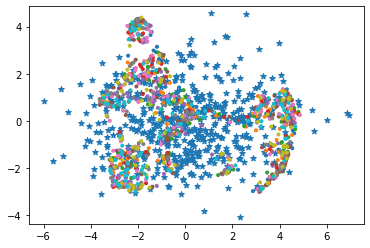

In [348]:
%matplotlib inline

plt.scatter(*sa.output_embedding.data.cpu().t(), marker='*')
plt.scatter(*embedding.T, c=np.arange(0, len(dt.centers)), cmap='tab10', marker='.')
plt.axis('equal')
plt.show()

### Forward propagate using the Spatial Attention

In [349]:
class SpatialMLP(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        NC = 1000
        self.dt = dtnn.DistanceTransform_MinExp(784, NC).to(device)
        self.dt.set_centroid_to_data_randomly(train_loader)
#         self.dt.centers.requires_grad=False
        
        embedder = umap.UMAP(densmap=True, n_neighbors=10, n_components=2, min_dist=0.1, spread=1)
        embedding = embedder.fit_transform(self.dt.centers.data.cpu().numpy())
        embedding = embedding - embedding.mean(axis=0, keepdims=True)
        
        self.input_embedding = nn.Parameter(torch.Tensor(embedding))
        
        self.sa1 = SpatialAttention(1000, 500, out_neighbours=150, inp_neighbours=500, embedding_dim=2)
#         self.sa1.hardness = 1
        self.sa2 = SpatialAttention(500, 500, out_neighbours=100, inp_neighbours=100, embedding_dim=2)
#         self.sa2.hardness = 1

        self.linear = nn.Linear(500, 10)
        self.actf = nn.ReLU()
        
    def forward(self, x):
        x = self.dt(x)
        x = self.sa1(x, self.input_embedding)#.to(x.device))
        x = self.actf(x)
        x = self.sa2(x, self.sa1.output_embedding)
        x = self.actf(x)
        x = self.linear(x)
        return x

In [350]:
model = SpatialMLP().to(device)

pg1, pg2 = [], [model.sa1.output_embedding, model.sa2.output_embedding, model.input_embedding]
for params in model.parameters():
    try:
        if params.shape[1] == 2: continue
    except:
        pass
    pg1.append(params)

In [351]:
optimizer = optim.AdamW(pg1, lr=0.0001)
criterion = nn.CrossEntropyLoss()

weight_params = [model.sa1.weights, model.sa2.weights]
optimizer1 = optim.AdamW(pg2, lr=0.0003, )

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 0:0,  Loss:1.0119118690490723
Train Acc:53.33%, Test Acc:69.05%
Weight mean abs value: 0.04666155204176903



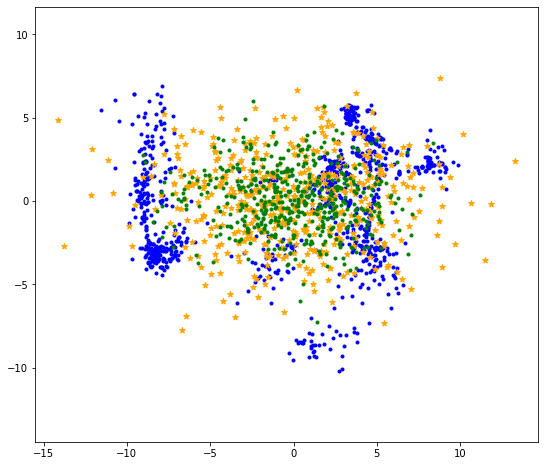

  1%|▏         | 1/80 [00:13<17:53, 13.59s/it]


KeyboardInterrupt: 

In [352]:
index = 0
train_accs, test_accs = [], []

## initial hardness is 0.25... increase [0.5, 1, 2, 4, 8]
# hardness_double = [9, 18, 25, 31, 37]
hardness_double = [20, 40, 55, 69] ## in 80

for epoch in tqdm(list(range(80))):
    train_acc = 0
    train_count = 0
    model.train()
    for xx, yy in train_loader:
        xx, yy = xx.to(device), yy.to(device)
        yout = model(xx)
        loss = criterion(yout, yy)
        
        optimizer.zero_grad(); optimizer1.zero_grad()
        loss.backward()
        optimizer.step(); optimizer1.step()
        
        ### move weight parameters towards 1 or -1
#         for wp in weight_params:
#             wp = wp - 0.1*torch.sign(wp - torch.sign(wp))
            ## for example wp = [-1.1, -0.5, 0.5, 1.1]
            ## sign(-0.1, 0.5, -0.5, 0.1) = [-1, 1, -1, 1]
            ## eqv to -> move to given sign
#             del_wp = wp - torch.sign(wp)
#             wp = wp - 0.01*torch.sign(del_wp)*del_wp
            

        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        train_acc += correct
        train_count += len(outputs)
#         break

    train_accs.append(float(train_acc)/train_count*100)
    train_acc = 0
    train_count = 0
    
    if epoch in hardness_double:
#         _hrd = 0.5*(2**(hardness_double.index(epoch)+1))
#         model.sa1.hardness = _hrd
#         model.sa2.hardness = _hrd
        model.sa1.hardness *= 2
        model.sa2.hardness *= 2
        print(f"Hardness changed to {model.sa2.hardness}")
    
    print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
    test_count = 0
    test_acc = 0
    
    model.eval()
    for xx, yy in test_loader:
        xx, yy = xx.to(device), yy.to(device)
        with torch.no_grad():
            yout = model(xx)
        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        test_acc += correct
        test_count += len(xx)
#         break
    test_accs.append(float(test_acc)/test_count*100)
    print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
    print(f"Weight mean abs value: {float(model.sa1.weights.data.abs().mean())}")    
    print()

    plt.figure(figsize=(9,8))
    plt.scatter(*model.input_embedding.data.cpu().t(), marker='.', color='b')
    plt.scatter(*model.sa1.output_embedding.data.cpu().t(), marker='*', color='orange')
    plt.scatter(*model.sa2.output_embedding.data.cpu().t(), marker='.', color='g')

    plt.axis('equal')
    plt.show()
    

### after each class index is finished training
print(f'\t-> MAX Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}')

In [ ]:
# model.sa1.hardness = 1
# model.sa2.hardness = 1

In [353]:
print(f"Weight mean abs value: {float(model.sa1.weights.data.abs().mean())}")  
print(f"Weight mean abs value: {float(model.sa2.weights.data.abs().mean())}")  

Weight mean abs value: 0.05111488327383995
Weight mean abs value: 0.042339883744716644


In [354]:
model.sa1.weights.data.abs().min()

tensor(1.7106e-07, device='cuda:1')

In [355]:
### Train Acc:94.87%, Test Acc:87.72% -> hardness 8 [d:500, sa:150/500, 100/500]
### Train Acc:88.31%, Test Acc:84.31% -> hardness 8 [d:500, sa:50/500, 10/500]

In [356]:
# torch.save(model.state_dict(), "./models/06_6_multilayer_spatial_embedding_v0.pth")

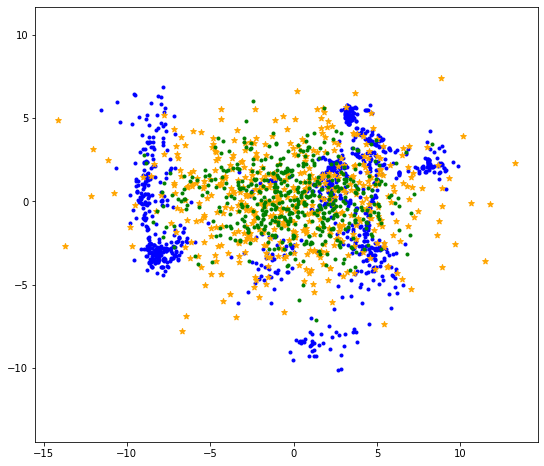

In [357]:
%matplotlib inline
plt.figure(figsize=(9,8))
plt.scatter(*model.input_embedding.data.cpu().t(), marker='.', color='b')
plt.scatter(*model.sa1.output_embedding.data.cpu().t(), marker='*', color='orange')
plt.scatter(*model.sa2.output_embedding.data.cpu().t(), marker='.', color='g')

plt.axis('equal')
plt.show()

### activation pattern for individual input

Index 7931


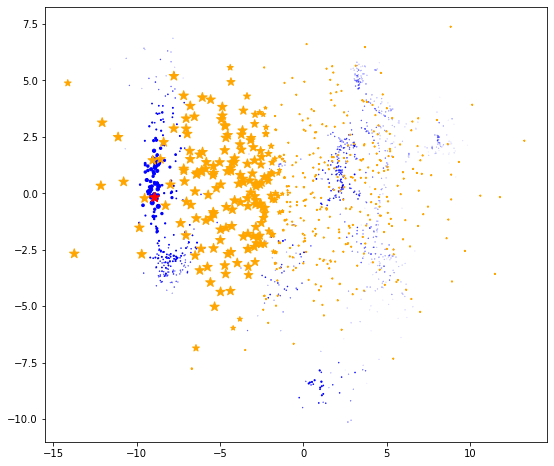

In [395]:
indices = np.random.randint(0, len(test_loader.dataset.data))
print(f"Index {indices}")
xx, yy = test_loader.dataset[[indices]]

plt.figure(figsize=(9,8))
x = model.dt(xx.to(device))
plt.scatter(*model.input_embedding.data.cpu().t(), marker='.', color='b', s=x[0].data.cpu()*100)


with torch.no_grad():
    avg_emb = x.abs()**10
    avg_emb = avg_emb/torch.sum(avg_emb, dim=1, keepdims=True)
avg_emb = avg_emb@model.input_embedding
plt.scatter(float(avg_emb[0,0]), float(avg_emb[0,1]), marker='*', c='r', s=100)
# plt.show()


### select output neurons

avg_emb_ = torch.cat([avg_emb, torch.zeros(len(avg_emb), 1).to(h.device)], dim=1)
output_embedding_ = torch.cat([model.sa1.output_embedding, torch.ones(len(model.sa1.output_embedding), 1).to(h.device)], dim=1)
#### take distance between embeddings
edist = torch.cdist(avg_emb_, output_embedding_)


#### first scale distance to generalized gaussian to select K-nearest neighbours
A = 8

topk_edist, _ = torch.topk(edist, k=model.sa1.out_neighbours, dim=1, largest=False, sorted=True)
edge_dist = topk_edist[:, -1:] ## this is equivalent to (1/b)
b = 1/(edge_dist*1.05)
scaler = torch.exp(-((edist * b).abs()**(2*A)))


# plt.figure(figsize=(9,8))
plt.scatter(*model.sa1.output_embedding.data.cpu().t(), marker='*', color='orange', 
            s=torch.clamp_min(scaler.data.cpu()*100, 2))
plt.scatter(float(avg_emb[0,0]), float(avg_emb[0,1]), marker='*', c='r', s=100)
plt.show()
        
#         input_embedding_ = torch.cat([self.input_embedding, torch.zeros(len(self.input_embedding), 1).to(x.device)], dim=1)
#         output_embedding_ = torch.cat([self.output_embedding, torch.ones(len(self.output_embedding), 1).to(x.device)], dim=1)
#         edist1 = torch.cdist(input_embedding_, output_embedding_)

#         topk_edist1, _ = torch.topk(edist1, k=self.inp_neighbours, dim=0, largest=False, sorted=True)
#         edge_dist1 = topk_edist1[-1:]
#         b1 = 1/(edge_dist1*1.05)
#         scaler1 = torch.exp(-((edist1 * b1).abs()**(2*A)))

#         self.W1 = scaler1
        
#         KM = scaler
        
#         ## use this to scale the weights
#         ytemp = torch.matmul(x, self.weights*scaler1)
#         y = self.bn(ytemp*KM)



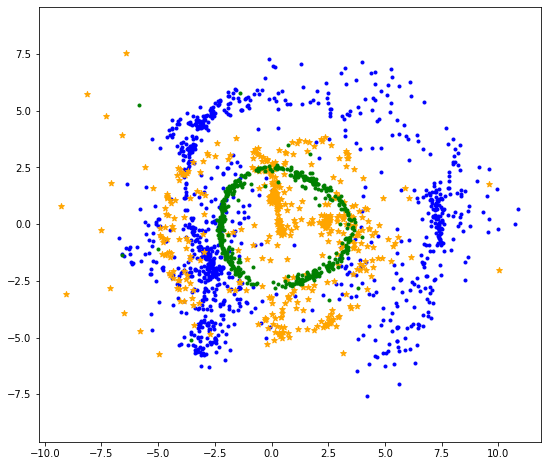

In [170]:
%matplotlib inline
plt.figure(figsize=(9,8))
plt.scatter(*model.input_embedding.data.cpu().t(), marker='.', color='b')
plt.scatter(*model.sa1.output_embedding.data.cpu().t(), marker='*', color='orange')
plt.scatter(*model.sa2.output_embedding.data.cpu().t(), marker='.', color='g')

plt.axis('equal')
plt.show()

In [225]:
model.sa1.W1[0].sum()

tensor(88.3960, device='cuda:1', grad_fn=<SumBackward0>)

In [226]:
model.sa1.weights

Parameter containing:
tensor([[ 0.0233,  0.0033,  0.0147,  ..., -0.0009,  0.0018,  0.0178],
        [-0.0319,  0.0333, -0.0327,  ..., -0.0003,  0.0243,  0.0316],
        [-0.0089,  0.0238,  0.0460,  ...,  0.0442, -0.0305, -0.0298],
        ...,
        [ 0.0275, -0.0092, -0.0108,  ..., -0.0334,  0.0262, -0.0137],
        [ 0.0041, -0.0142,  0.0161,  ...,  0.0280, -0.0147, -0.0028],
        [ 0.0039, -0.0040,  0.0173,  ...,  0.0030,  0.0020, -0.0207]],
       device='cuda:1', requires_grad=True)

In [227]:
line_collection = []
weight_collection = []

sa = model.sa2

saW = sa.W1 #W1
for i, inp in enumerate(tqdm(sa.input_embedding)):
    p0 = tuple(inp.tolist())
    for j, out in enumerate(sa.output_embedding):
        p1 = tuple(out.tolist())
        
        line_collection.append([p0,p1])
        weight_collection.append(float(saW[i,j]))
#         break
        
line_collection, weight_collection = np.array(line_collection), np.array(weight_collection)

100%|██████████| 500/500 [00:08<00:00, 59.17it/s]


In [228]:
line_collection

array([[[ 6.20872164, -1.43258631],
        [ 2.09677243,  1.29766738]],

       [[ 6.20872164, -1.43258631],
        [ 0.30089027, -0.23256636]],

       [[ 6.20872164, -1.43258631],
        [ 0.94774127,  1.05579865]],

       ...,

       [[ 1.42811584,  1.21658742],
        [ 1.02884603, -1.29337931]],

       [[ 1.42811584,  1.21658742],
        [ 1.10054243,  0.58583808]],

       [[ 1.42811584,  1.21658742],
        [ 2.36809063,  0.35493451]]])

In [229]:
weight_collection

array([8.20512135e-24, 0.00000000e+00, 0.00000000e+00, ...,
       2.66280631e-03, 9.31950092e-01, 6.20703638e-01])

In [230]:
weight_collection.min(), weight_collection.max()

(0.0, 1.0)

In [231]:
from matplotlib import collections
import matplotlib as mpl

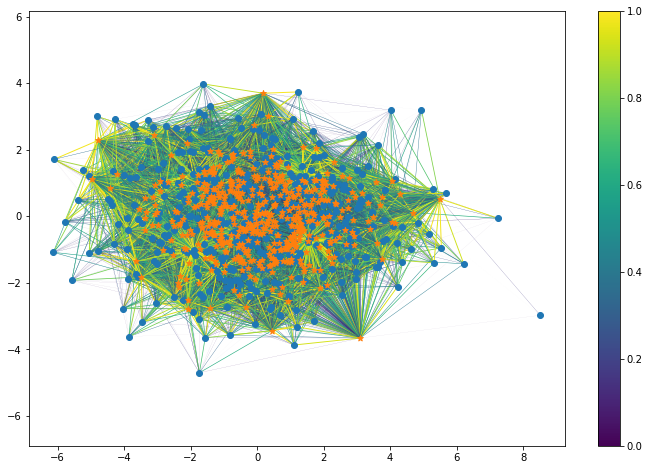

In [232]:
## plot attention weights
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

# lc = collections.LineCollection(line_collection, linewidths=weight_collection*5, zorder=-2)
lc = collections.LineCollection(line_collection, 
                                array=weight_collection, 
                                linewidths= weight_collection, 
#                                 norm=mpl.colors.Normalize(vmin=-0, vmax=2),
#                                 cmap="PiYG", 
                                zorder=-2, )

# lc.set_array(weight_collection)
ax.add_collection(lc)
axcb = fig.colorbar(lc)

# ax.autoscale()
# ax.margins(0.1)

plt.scatter(*sa.input_embedding.data.cpu().t(), cmap='tab10', marker='o')
plt.scatter(*sa.output_embedding.data.cpu().t(), marker='*')

plt.axis('equal')
plt.show()

In [233]:
sa.hardness

2.0

In [66]:
### Test using same neurons

class SimpleMLP(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        NC = 100
        self.dt = dtnn.DistanceTransform_Exp(784, NC).to(device)
        self.dt.set_centroid_to_data_randomly(train_loader)
        
#         self.sa1 = nn.Linear(NC, 150)
#         self.bn1 = nn.BatchNorm1d(150)
#         self.sa2 = nn.Linear(150, 100)
#         self.bn2 = nn.BatchNorm1d(100)
        self.sa1 = nn.Linear(NC, 80)
        self.bn1 = nn.BatchNorm1d(80)
        self.sa2 = nn.Linear(80, 20)
        self.bn2 = nn.BatchNorm1d(20)

        self.linear = nn.Linear(20, 10)
        self.actf = nn.ELU()
        
    def forward(self, x):
        x = self.dt(x)
        x = self.sa1(x)
        x = self.bn1(x)
        x = self.actf(x)
        x = self.sa2(x)
        x = self.bn2(x)
        x = self.actf(x)
        x = self.linear(x)
        return x

In [67]:
model = SimpleMLP().to(device)

optimizer = optim.Adam(list(model.parameters()), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [68]:
index = 0
train_accs, test_accs = [], []
model.train()

for epoch in tqdm(list(range(40*2))):
    train_acc = 0
    train_count = 0
    for xx, yy in train_loader:
        xx, yy = xx.to(device), yy.to(device)
        yout = model(xx)
        loss = criterion(yout, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        train_acc += correct
        train_count += len(outputs)

    train_accs.append(float(train_acc)/train_count*100)
    train_acc = 0
    train_count = 0
    
    print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
    test_count = 0
    test_acc = 0
    for xx, yy in test_loader:
        xx, yy = xx.to(device), yy.to(device)
        with torch.no_grad():
            yout = model(xx)
        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        test_acc += correct
        test_count += len(xx)
    test_accs.append(float(test_acc)/test_count*100)
    print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
    print()

### after each class index is finished training
print(f'\t-> MAX Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}')

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 0:0,  Loss:0.810994029045105


  1%|▏         | 1/80 [00:03<04:48,  3.65s/it]

Train Acc:67.20%, Test Acc:76.42%

Epoch: 1:0,  Loss:0.6905146241188049


  2%|▎         | 2/80 [00:07<04:43,  3.63s/it]

Train Acc:79.13%, Test Acc:80.00%

Epoch: 2:0,  Loss:0.8879266977310181


  4%|▍         | 3/80 [00:10<04:38,  3.62s/it]

Train Acc:81.76%, Test Acc:81.69%

Epoch: 3:0,  Loss:0.4741152822971344


  5%|▌         | 4/80 [00:14<04:35,  3.62s/it]

Train Acc:83.00%, Test Acc:82.62%

Epoch: 4:0,  Loss:0.40005970001220703


  6%|▋         | 5/80 [00:18<04:31,  3.62s/it]

Train Acc:84.00%, Test Acc:83.23%

Epoch: 5:0,  Loss:0.40762463212013245


  8%|▊         | 6/80 [00:21<04:26,  3.60s/it]

Train Acc:84.67%, Test Acc:83.90%

Epoch: 6:0,  Loss:0.23511803150177002


  9%|▉         | 7/80 [00:25<04:23,  3.61s/it]

Train Acc:85.15%, Test Acc:84.35%

Epoch: 7:0,  Loss:0.4097784757614136


 10%|█         | 8/80 [00:28<04:20,  3.62s/it]

Train Acc:85.59%, Test Acc:84.27%

Epoch: 8:0,  Loss:0.5447670817375183


 11%|█▏        | 9/80 [00:32<04:16,  3.62s/it]

Train Acc:85.88%, Test Acc:84.29%

Epoch: 9:0,  Loss:0.5814881920814514


 12%|█▎        | 10/80 [00:36<04:13,  3.62s/it]

Train Acc:86.22%, Test Acc:84.91%

Epoch: 10:0,  Loss:0.1859889030456543


 14%|█▍        | 11/80 [00:39<04:08,  3.60s/it]

Train Acc:86.58%, Test Acc:84.83%

Epoch: 11:0,  Loss:0.5033188462257385


 15%|█▌        | 12/80 [00:43<04:04,  3.60s/it]

Train Acc:86.65%, Test Acc:85.05%

Epoch: 12:0,  Loss:0.2119940221309662


 16%|█▋        | 13/80 [00:46<04:00,  3.59s/it]

Train Acc:86.94%, Test Acc:85.33%

Epoch: 13:0,  Loss:0.20822790265083313


 18%|█▊        | 14/80 [00:50<03:57,  3.60s/it]

Train Acc:87.18%, Test Acc:85.15%

Epoch: 14:0,  Loss:0.4753336012363434


 19%|█▉        | 15/80 [00:54<03:54,  3.60s/it]

Train Acc:87.41%, Test Acc:85.74%

Epoch: 15:0,  Loss:0.32525435090065


 20%|██        | 16/80 [00:57<03:49,  3.59s/it]

Train Acc:87.63%, Test Acc:85.96%

Epoch: 16:0,  Loss:0.2738696336746216


 21%|██▏       | 17/80 [01:01<03:45,  3.58s/it]

Train Acc:87.66%, Test Acc:85.96%

Epoch: 17:0,  Loss:0.18907615542411804


 22%|██▎       | 18/80 [01:04<03:43,  3.60s/it]

Train Acc:87.88%, Test Acc:86.22%

Epoch: 18:0,  Loss:0.2888869345188141


 24%|██▍       | 19/80 [01:08<03:39,  3.60s/it]

Train Acc:88.00%, Test Acc:86.38%

Epoch: 19:0,  Loss:0.2839687764644623


 25%|██▌       | 20/80 [01:12<03:36,  3.61s/it]

Train Acc:88.01%, Test Acc:86.31%

Epoch: 20:0,  Loss:0.31814658641815186


 26%|██▋       | 21/80 [01:15<03:34,  3.63s/it]

Train Acc:88.25%, Test Acc:86.67%

Epoch: 21:0,  Loss:0.31255462765693665


 28%|██▊       | 22/80 [01:19<03:30,  3.63s/it]

Train Acc:88.25%, Test Acc:86.72%

Epoch: 22:0,  Loss:0.19443267583847046


 29%|██▉       | 23/80 [01:23<03:26,  3.62s/it]

Train Acc:88.45%, Test Acc:86.31%

Epoch: 23:0,  Loss:0.38098594546318054


 30%|███       | 24/80 [01:26<03:23,  3.63s/it]

Train Acc:88.52%, Test Acc:86.59%

Epoch: 24:0,  Loss:0.31011033058166504


 31%|███▏      | 25/80 [01:30<03:20,  3.64s/it]

Train Acc:88.61%, Test Acc:86.71%

Epoch: 25:0,  Loss:0.5824552774429321


 32%|███▎      | 26/80 [01:33<03:16,  3.63s/it]

Train Acc:88.72%, Test Acc:86.83%

Epoch: 26:0,  Loss:0.14107665419578552


 34%|███▍      | 27/80 [01:37<03:12,  3.62s/it]

Train Acc:88.72%, Test Acc:86.83%

Epoch: 27:0,  Loss:0.161645770072937


 35%|███▌      | 28/80 [01:41<03:09,  3.65s/it]

Train Acc:88.91%, Test Acc:86.94%

Epoch: 28:0,  Loss:0.2634226381778717


 36%|███▋      | 29/80 [01:44<03:06,  3.66s/it]

Train Acc:88.92%, Test Acc:86.90%

Epoch: 29:0,  Loss:0.14161163568496704


 38%|███▊      | 30/80 [01:48<03:03,  3.67s/it]

Train Acc:89.03%, Test Acc:86.95%

Epoch: 30:0,  Loss:0.28614693880081177


 39%|███▉      | 31/80 [01:52<02:58,  3.65s/it]

Train Acc:89.03%, Test Acc:86.87%

Epoch: 31:0,  Loss:0.30785512924194336


 40%|████      | 32/80 [01:55<02:53,  3.62s/it]

Train Acc:89.15%, Test Acc:86.75%

Epoch: 32:0,  Loss:0.3427525758743286


 41%|████▏     | 33/80 [01:59<02:49,  3.60s/it]

Train Acc:89.31%, Test Acc:87.19%

Epoch: 33:0,  Loss:0.29964205622673035


 42%|████▎     | 34/80 [02:03<02:46,  3.63s/it]

Train Acc:89.28%, Test Acc:86.82%

Epoch: 34:0,  Loss:0.4288252592086792


 44%|████▍     | 35/80 [02:06<02:43,  3.64s/it]

Train Acc:89.40%, Test Acc:87.27%

Epoch: 35:0,  Loss:0.11779577285051346


 45%|████▌     | 36/80 [02:10<02:40,  3.65s/it]

Train Acc:89.49%, Test Acc:87.17%

Epoch: 36:0,  Loss:0.24490532279014587


 46%|████▋     | 37/80 [02:14<02:37,  3.66s/it]

Train Acc:89.58%, Test Acc:87.20%

Epoch: 37:0,  Loss:0.16209405660629272


 48%|████▊     | 38/80 [02:17<02:34,  3.67s/it]

Train Acc:89.57%, Test Acc:87.22%

Epoch: 38:0,  Loss:0.40616169571876526


 49%|████▉     | 39/80 [02:21<02:30,  3.67s/it]

Train Acc:89.62%, Test Acc:87.41%

Epoch: 39:0,  Loss:0.19896185398101807


 50%|█████     | 40/80 [02:25<02:26,  3.65s/it]

Train Acc:89.67%, Test Acc:86.91%

Epoch: 40:0,  Loss:0.40239372849464417


 51%|█████▏    | 41/80 [02:28<02:22,  3.65s/it]

Train Acc:89.74%, Test Acc:87.37%

Epoch: 41:0,  Loss:0.2790905833244324


 52%|█████▎    | 42/80 [02:32<02:18,  3.64s/it]

Train Acc:89.84%, Test Acc:87.00%

Epoch: 42:0,  Loss:0.23673704266548157


 54%|█████▍    | 43/80 [02:35<02:13,  3.62s/it]

Train Acc:89.83%, Test Acc:87.32%

Epoch: 43:0,  Loss:0.24043211340904236


 55%|█████▌    | 44/80 [02:39<02:10,  3.63s/it]

Train Acc:89.99%, Test Acc:87.44%

Epoch: 44:0,  Loss:0.4287777841091156


 56%|█████▋    | 45/80 [02:43<02:07,  3.64s/it]

Train Acc:89.99%, Test Acc:87.56%

Epoch: 45:0,  Loss:0.2326313555240631


 57%|█████▊    | 46/80 [02:46<02:03,  3.64s/it]

Train Acc:90.09%, Test Acc:87.48%

Epoch: 46:0,  Loss:0.1553685963153839


 59%|█████▉    | 47/80 [02:50<01:59,  3.64s/it]

Train Acc:90.15%, Test Acc:87.43%

Epoch: 47:0,  Loss:0.13119450211524963


 60%|██████    | 48/80 [02:54<01:55,  3.61s/it]

Train Acc:90.10%, Test Acc:87.36%

Epoch: 48:0,  Loss:0.19353091716766357


 61%|██████▏   | 49/80 [02:57<01:52,  3.63s/it]

Train Acc:90.11%, Test Acc:87.29%

Epoch: 49:0,  Loss:0.32159024477005005


 62%|██████▎   | 50/80 [03:01<01:48,  3.62s/it]

Train Acc:90.35%, Test Acc:87.41%

Epoch: 50:0,  Loss:0.16189032793045044


 64%|██████▍   | 51/80 [03:04<01:44,  3.61s/it]

Train Acc:90.16%, Test Acc:87.58%

Epoch: 51:0,  Loss:0.26630812883377075


 65%|██████▌   | 52/80 [03:08<01:41,  3.62s/it]

Train Acc:90.24%, Test Acc:87.47%

Epoch: 52:0,  Loss:0.2991677522659302


 66%|██████▋   | 53/80 [03:12<01:37,  3.62s/it]

Train Acc:90.41%, Test Acc:87.50%

Epoch: 53:0,  Loss:0.12698139250278473


 68%|██████▊   | 54/80 [03:15<01:33,  3.59s/it]

Train Acc:90.38%, Test Acc:87.35%

Epoch: 54:0,  Loss:0.15765710175037384


 69%|██████▉   | 55/80 [03:19<01:29,  3.59s/it]

Train Acc:90.39%, Test Acc:87.46%

Epoch: 55:0,  Loss:0.12096266448497772


 70%|███████   | 56/80 [03:22<01:26,  3.62s/it]

Train Acc:90.51%, Test Acc:87.49%

Epoch: 56:0,  Loss:0.23142914474010468


 71%|███████▏  | 57/80 [03:26<01:23,  3.62s/it]

Train Acc:90.53%, Test Acc:87.44%

Epoch: 57:0,  Loss:0.1517198532819748


 72%|███████▎  | 58/80 [03:30<01:20,  3.64s/it]

Train Acc:90.56%, Test Acc:87.38%

Epoch: 58:0,  Loss:0.22389642894268036


 74%|███████▍  | 59/80 [03:33<01:16,  3.62s/it]

Train Acc:90.72%, Test Acc:87.79%

Epoch: 59:0,  Loss:0.15523932874202728


 75%|███████▌  | 60/80 [03:37<01:12,  3.64s/it]

Train Acc:90.75%, Test Acc:87.38%

Epoch: 60:0,  Loss:0.1680733561515808


 76%|███████▋  | 61/80 [03:41<01:08,  3.63s/it]

Train Acc:90.80%, Test Acc:87.41%

Epoch: 61:0,  Loss:0.2460111677646637


 78%|███████▊  | 62/80 [03:44<01:05,  3.62s/it]

Train Acc:90.77%, Test Acc:87.85%

Epoch: 62:0,  Loss:0.3113609552383423


 79%|███████▉  | 63/80 [03:48<01:01,  3.60s/it]

Train Acc:90.86%, Test Acc:87.86%

Epoch: 63:0,  Loss:0.15393565595149994


 80%|████████  | 64/80 [03:51<00:57,  3.61s/it]

Train Acc:90.95%, Test Acc:87.20%

Epoch: 64:0,  Loss:0.294908344745636


 81%|████████▏ | 65/80 [03:55<00:54,  3.60s/it]

Train Acc:90.94%, Test Acc:87.53%

Epoch: 65:0,  Loss:0.35088980197906494


 82%|████████▎ | 66/80 [03:59<00:50,  3.60s/it]

Train Acc:91.00%, Test Acc:87.59%

Epoch: 66:0,  Loss:0.15059664845466614


 84%|████████▍ | 67/80 [04:02<00:46,  3.59s/it]

Train Acc:91.12%, Test Acc:87.57%

Epoch: 67:0,  Loss:0.23956985771656036


 85%|████████▌ | 68/80 [04:06<00:43,  3.60s/it]

Train Acc:91.04%, Test Acc:87.49%

Epoch: 68:0,  Loss:0.2997076213359833


 86%|████████▋ | 69/80 [04:09<00:39,  3.62s/it]

Train Acc:91.12%, Test Acc:87.73%

Epoch: 69:0,  Loss:0.13891896605491638


 88%|████████▊ | 70/80 [04:13<00:35,  3.57s/it]

Train Acc:91.23%, Test Acc:87.38%

Epoch: 70:0,  Loss:0.1883125901222229


 89%|████████▉ | 71/80 [04:17<00:32,  3.60s/it]

Train Acc:91.18%, Test Acc:87.74%

Epoch: 71:0,  Loss:0.2503613829612732


 90%|█████████ | 72/80 [04:20<00:28,  3.62s/it]

Train Acc:91.33%, Test Acc:87.80%

Epoch: 72:0,  Loss:0.2017858326435089


 91%|█████████▏| 73/80 [04:24<00:25,  3.60s/it]

Train Acc:91.25%, Test Acc:87.62%

Epoch: 73:0,  Loss:0.41934284567832947


 92%|█████████▎| 74/80 [04:27<00:21,  3.60s/it]

Train Acc:91.29%, Test Acc:87.85%

Epoch: 74:0,  Loss:0.3727191090583801


 94%|█████████▍| 75/80 [04:31<00:18,  3.60s/it]

Train Acc:91.38%, Test Acc:87.66%

Epoch: 75:0,  Loss:0.11835931986570358


 95%|█████████▌| 76/80 [04:35<00:14,  3.62s/it]

Train Acc:91.43%, Test Acc:87.62%

Epoch: 76:0,  Loss:0.255188912153244


 96%|█████████▋| 77/80 [04:38<00:10,  3.63s/it]

Train Acc:91.31%, Test Acc:87.86%

Epoch: 77:0,  Loss:0.20728513598442078


 98%|█████████▊| 78/80 [04:42<00:07,  3.62s/it]

Train Acc:91.36%, Test Acc:87.76%

Epoch: 78:0,  Loss:0.28869113326072693


 99%|█████████▉| 79/80 [04:45<00:03,  3.60s/it]

Train Acc:91.50%, Test Acc:87.71%

Epoch: 79:0,  Loss:0.26076385378837585


100%|██████████| 80/80 [04:49<00:00,  3.62s/it]

Train Acc:91.55%, Test Acc:87.53%

	-> MAX Train Acc 91.55333333333333 ; Test Acc 87.86


In [ ]:
## -> MAX Train Acc 91.36333333333333 ; Test Acc 88.46
